# AIMET Demo - Notebook

Notebook containing all the steps for using AIMET, a clinical decision suport system capable of differentiating multisystem inflammatory syndrome in children (MIS-C) from typhus.


## Imports
Libraries and packages used for AIMET tool.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

## Loading Data

Folder that contents all data required to run the Jupyter Notebook.

In [2]:
os.chdir('..')
cwd = os.getcwd()
print(cwd)

/home/abautis4@cougarnet.uh.edu/Documents/Typhus-Project/Github


In [3]:
data_folder = cwd + "/Data/"
print(data_folder)

/home/abautis4@cougarnet.uh.edu/Documents/Typhus-Project/Github/Data/


Dataset CSV file.

In [4]:
df = pd.read_csv(data_folder + 'dataset.csv')

In [5]:
df.head(10)

,MRN,Age (years),Gender,Epidemiologic link to SARS-CoV-2,FEVER fever before hospital,FEVER Tmax xxx or greater until next degree,Lowest systolic BP in ED (within first two hours of presentation),Lowest diastolic BP in ED (within first two hours of presentation),Highest heart rate in ED (within first two hours of presentation),Antecedent Illness,...,"Platelets, admission","AST, admission","ALT, admission","Sodium, admission","Troponin, admission","BNP, admission","Fibrinogen, admission",LDH,PATIENT HAD TYPHUS?,PATIENT HAD MISC?
0,FRHQ53971,17.0,Female,Yes,10.0,105.0,75.0,39.0,116.0,No,...,385.0,101.0,53.0,133.0,2.446,323.6,772.0,802.0,No,Yes
1,ZWZJ23529,15.0,Female,Yes,6.0,103.0,91.0,42.0,115.0,Yes,...,203.0,22.0,20.0,139.0,0.010,518.0,704.0,565.0,No,Yes
2,SDBJ73753,5.0,Male,No,5.0,103.0,95.0,53.0,120.0,No,...,400.0,41.0,16.0,137.0,0.010,43.7,577.0,875.0,No,Yes
3,JLFE85476,5.0,Male,No,5.0,104.0,106.0,58.0,116.0,No,...,126.0,42.0,18.0,128.0,0.010,16.2,546.0,684.0,No,Yes
4,GCKX65582,10.0,Female,Yes,5.0,103.0,91.0,53.0,154.0,No,...,150.0,70.0,50.0,135.0,0.030,NaN,489.0,956.0,No,Yes
5,GAPP44528,1.4,Male,No,3.0,103.0,99.0,68.0,176.0,Yes,...,343.0,26.0,11.0,135.0,0.010,289.1,416.0,1081.0,No,Yes
6,VKBP80835,16.0,Male,Yes,5.0,103.0,110.0,63.0,120.0,No,...,189.0,72.0,56.0,135.0,0.125,14.0,511.0,3381.0,No,Yes
7,TYBB30539,3.0,Male,Yes,5.0,104.0,82.0,47.0,153.0,No,...,173.0,84.0,25.0,135.0,0.363,NaN,612.0,909.0,No,Yes
8,NMVV95145,7.0,Male,No,5.0,105.0,88.0,36.0,174.0,No,...,50.0,153.0,83.0,134.0,0.042,729.0,501.0,1393.0,No,Yes
9,KCFU35705,11.0,Male,Yes,6.0,104.0,80.0,47.0,143.0,No,...,196.0,39.0,36.0,125.0,0.029,544.0,733.0,597.0,No,Yes


## Pre-processing Library Functions

Function to categorize clinical features based on even up to four parameters: low, high, gender, and age. 

In [6]:
def int2cat(df=None, column=None, low = None, high = None, gender = None, age = None):
    
    #check for columns and creates new columns if there are not there
    if low != None and column + ' - Low' not in df.columns:
        df[column + ' - Low'] = 0
    if high != None and column + ' - High' not in df.columns:
        df[column + ' - High'] = 0
    if column + ' - Normal' not in df.columns:
        df[column + ' - Normal'] = 0

    #check if age and gender matters to categorize the feature
    if age != None and gender != None:
        if low != None:
            df[column + ' - Low'].loc[(df['Gender']==gender)&
                                      (df['Age (years)']>=age[0])&
                                      (df['Age (years)']<age[1])&
                                      (df[column]<low)] = 1   
        if high != None:
            df[column + ' - High'].loc[(df['Gender']==gender)&
                                       (df['Age (years)']>=age[0])&
                                       (df['Age (years)']<age[1])&
                                       (df[column]>high)] = 1
            
        df[column + ' - Normal'].loc[(df['Gender']==gender)&
                                     (df['Age (years)']>=age[0])&
                                     (df['Age (years)']<age[1])&
                                     (df[column]>=low)&
                                     (df[column]<=high)] = 1
        
    #in case that age and gender don't matter to categorize the feature
    if age == None and gender == None:
        if low != None:
            df[column + ' - Low'].loc[(df[column]<low)] = 1
            
        if high != None:
            df[column + ' - High'].loc[(df[column]>high)] = 1
        
        if low == None:
            df[column + ' - Normal'].loc[(df[column]<=high)] = 1
        
        if high == None:
            df[column + ' - Normal'].loc[(df[column]>=low)] = 1
        
        df[column + ' - Normal'].loc[(df[column]>=low)&
                                     (df[column]<=high)] = 1
                
    return df

Binary encoding function.

In [7]:
def bin_encoding(df=None, column=None, zero=None, one=None):
    
    df[column] = df[column].replace(zero,0)
    df[column] = df[column].replace(one,1)
    
    return df

List comparison function.

In [8]:
def list_dif(list1, list2):
    
    diff = [i for i in list1 + list2 if i not in list1 or i not in list2]
    
    return diff

## MET-17: Pre-processing

Columns for MET-17.

In [57]:
columns_17 =['MRN',
             'Age (years)',
             'Gender',
             'Epidemiologic link to SARS-CoV-2', 
             'FEVER fever before hospital ', 
             'FEVER Tmax xxx or greater until next degree ',
             'Highest heart rate in ED (within first two hours of presentation)',
             'Antecedent Illness',
             'Conjunctivitis', 
             'Rash', 
             'ALC, admission',
             'ANC, admission',
             'AST, admission',
             'ALT, admission',
             'Sodium, admission',
             'Troponin, admission',
             'BNP, admission',
             'Fibrinogen, admission',
             'PATIENT HAD TYPHUS?',
             'PATIENT HAD MISC?']

Dataframe for MET-17.

In [12]:
df_17 = df[columns_17]

Categorization of the AST clinical feature based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [13]:
df_17 = int2cat(df= df_17, column='AST, admission', low=20, high=60, gender='Female', age=[0,4])
df_17 = int2cat(df= df_17, column='AST, admission', low=15, high=50, gender='Female', age=[4,7])
df_17 = int2cat(df= df_17, column='AST, admission', low=15, high=40, gender='Female', age=[7,10])
df_17 = int2cat(df= df_17, column='AST, admission', low=10, high=40, gender='Female', age=[10,12])
df_17 = int2cat(df= df_17, column='AST, admission', low=10, high=30, gender='Female', age=[12,16])
df_17 = int2cat(df= df_17, column='AST, admission', low=5,  high=30, gender='Female', age=[16,25])
df_17 = int2cat(df= df_17, column='AST, admission', low=20, high=60, gender='Male', age=[0,4])
df_17 = int2cat(df= df_17, column='AST, admission', low=15, high=50, gender='Male', age=[4,7])
df_17 = int2cat(df= df_17, column='AST, admission', low=15, high=40, gender='Male', age=[7,10])
df_17 = int2cat(df= df_17, column='AST, admission', low=10, high=60, gender='Male', age=[10,12])
df_17 = int2cat(df= df_17, column='AST, admission', low=15, high=40, gender='Male', age=[12,16])
df_17 = int2cat(df= df_17, column='AST, admission', low=10, high=45, gender='Male', age=[16,25])

Categorization of the ALT clinical feature based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [14]:
df_17 = int2cat(df= df_17, column='ALT, admission', low=14, high=45, gender='Female', age=[0,4])
df_17 = int2cat(df= df_17, column='ALT, admission', low=11, high=28, gender='Female', age=[4,14])
df_17 = int2cat(df= df_17, column='ALT, admission', low=10, high=35, gender='Female', age=[14,25])
df_17 = int2cat(df= df_17, column='ALT, admission', low=12, high=45, gender='Male', age=[0,4])
df_17 = int2cat(df= df_17, column='ALT, admission', low=10, high=41, gender='Male', age=[4,14])
df_17 = int2cat(df= df_17, column='ALT, admission', low=11, high=26, gender='Male', age=[14,25])

Categorization of the clinical features Sodium, Troponin, Fibrinogen, ALC, ANC, and BNP based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [15]:
df_17 = int2cat(df= df_17, column='Sodium, admission', low=135, high=None, gender=None, age=None)
df_17 = int2cat(df= df_17, column='Troponin, admission', low=None, high=0.03, gender=None, age=None)
df_17 = int2cat(df= df_17, column='Fibrinogen, admission', low=220, high=440, gender=None, age=None)
df_17 = int2cat(df= df_17, column='ALC, admission', low=1500, high=None, gender=None, age=None)
df_17 = int2cat(df= df_17, column='ANC, admission', low=None, high=8, gender=None, age=None)
df_17 = int2cat(df= df_17, column='BNP, admission', low=None, high=200, gender=None, age=None)

Binary encoding for categorical features.

In [16]:
df_17 = bin_encoding(df=df_17, column='Gender', zero='Female', one='Male')
df_17 = bin_encoding(df=df_17, column='Epidemiologic link to SARS-CoV-2', zero='No', one='Yes')
df_17 = bin_encoding(df=df_17, column='Antecedent Illness', zero='No', one='Yes')
df_17 = bin_encoding(df=df_17, column='Conjunctivitis', zero='No', one='Yes')
df_17 = bin_encoding(df=df_17, column='Rash', zero='No', one='Yes')
df_17 = bin_encoding(df=df_17, column='PATIENT HAD TYPHUS?', zero='No', one='Yes')
df_17 = bin_encoding(df=df_17, column='PATIENT HAD MISC?', zero='No', one='Yes')

ANC/ALC ratio computation.

In [17]:
df_17['ANC/ALC ratio, admission'] = df['ANC, admission']/df['ALC, admission']

No-need features' dropping.

In [18]:
df_17 = df_17.drop(['ALC, admission',
                    'ANC, admission',
                    'AST, admission',
                    'ALT, admission',
                    'Sodium, admission',
                    'Troponin, admission',
                    'Fibrinogen, admission',
                    'BNP, admission'], axis=1)

Data imputation for continuous values.

In [19]:
df_17['FEVER fever before hospital '].fillna(df_17['FEVER fever before hospital '].mean() ,inplace=True)
df_17['FEVER Tmax xxx or greater until next degree '].fillna(df_17['FEVER Tmax xxx or greater until next degree '].mean() ,inplace=True)
df_17['Highest heart rate in ED (within first two hours of presentation)'].fillna(df_17['Highest heart rate in ED (within first two hours of presentation)'].mean() ,inplace=True)
df_17['ANC/ALC ratio, admission'].fillna(df_17['ANC/ALC ratio, admission'].mean() ,inplace=True)

Dataframe after pre-processing.

In [20]:
df_17.head(10)

,MRN,Age (years),Gender,Epidemiologic link to SARS-CoV-2,FEVER fever before hospital,FEVER Tmax xxx or greater until next degree,Highest heart rate in ED (within first two hours of presentation),Antecedent Illness,Conjunctivitis,Rash,...,"Fibrinogen, admission - Low","Fibrinogen, admission - High","Fibrinogen, admission - Normal","ALC, admission - Low","ALC, admission - Normal","ANC, admission - High","ANC, admission - Normal","BNP, admission - High","BNP, admission - Normal","ANC/ALC ratio, admission"
0,FRHQ53971,17.0,0,1,10.0,105.0,116.0,0,1,0,...,0,1,0,1,0,1,0,1,0,14.025000
1,ZWZJ23529,15.0,0,1,6.0,103.0,115.0,1,0,1,...,0,1,0,1,0,1,0,1,0,29.302326
2,SDBJ73753,5.0,1,0,5.0,103.0,120.0,0,1,1,...,0,1,0,1,0,0,1,0,1,5.034965
3,JLFE85476,5.0,1,0,5.0,104.0,116.0,0,1,1,...,0,1,0,1,0,0,1,0,1,8.553571
4,GCKX65582,10.0,0,1,5.0,103.0,154.0,0,1,1,...,0,1,0,1,0,0,1,0,0,5.508621
5,GAPP44528,1.4,1,0,3.0,103.0,176.0,1,1,1,...,0,0,1,1,0,1,0,1,0,6.250000
6,VKBP80835,16.0,1,1,5.0,103.0,120.0,0,0,0,...,0,1,0,1,0,1,0,0,1,32.582090
7,TYBB30539,3.0,1,1,5.0,104.0,153.0,0,1,0,...,0,1,0,1,0,0,1,0,0,5.560345
8,NMVV95145,7.0,1,0,5.0,105.0,174.0,0,1,1,...,0,1,0,1,0,0,1,1,0,8.888889
9,KCFU35705,11.0,1,1,6.0,104.0,143.0,0,1,0,...,0,1,0,1,0,1,0,1,0,18.177419


## MET-17: Evaluation 

Excel file with MET-17 values for categorical features.

In [21]:
df_score = pd.read_excel(data_folder + '/MET_Score-v10.xlsx')

MET-17 evaluation for every patient in the dataframe.

In [22]:
scores = []
df_17['MET-17'] = 'None'

for i in df_17.index:
    value = 0
    
    for feature in df_score['Feature']:
        
        if df_17[feature].loc[i] == 1:
            added_value = float(df_score['If True - Rounded'].loc[df_score['Feature'] == feature].values)
            value += added_value

        if df_17[feature].loc[i] == 0:
            added_value = float(df_score['If False - Rounded'].loc[df_score['Feature'] == feature].values)
            value += added_value
    
    age =  df_17['Age (years)'].loc[i]
    fbh =  df_17['FEVER fever before hospital '].loc[i]
    hhr =  df_17['Highest heart rate in ED (within first two hours of presentation)'].loc[i]
    ftm =  df_17['FEVER Tmax xxx or greater until next degree '].loc[i]
    anlc = df_17['ANC/ALC ratio, admission'].loc[i]

    if (age >= 11):
        added_value = 4
    if (age < 11):
        added_value = -4
    value += added_value
    
    if (fbh >= 7):
        added_value = 8
    if (fbh < 7):
        added_value = -8
    value += added_value
    
    if (hhr >= 124):
        added_value = -6
    if (hhr < 124):
        added_value = 6
    value += added_value
    
    if (ftm >= 103):
        added_value = -4
    if (ftm < 103):
        added_value = 4
    value += added_value
   
    if (anlc >= 3.67):
        added_value = -4
    if (anlc < 3.67):
        added_value = 4
    value += added_value
    
    value = value - 0
    value = (value+87)/184
    
    scores.append(value)
    
    ci_typhus  = 1/(1 + np.exp(-value*11.2+6.1))
    ci_misc    = (-1/(1 + np.exp(-value*11.2+6.1)))+1
    
    if ci_typhus >= 0.949:
        df_17['MET-17'].loc[i] = 'Typhus'
    
    if ci_misc >= 0.949:
        df_17['MET-17'].loc[i] = 'MIS-C'
        
    if (ci_typhus<0.949) and (ci_misc<0.949):
        df_17['MET-17'].loc[i] = 'Needs MET-30'

Calculation of True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN).

In [23]:
TP = len(df_17.loc[(df_17['MET-17'] == 'Typhus') & (df_17['PATIENT HAD TYPHUS?'] == 1)])
FP = len(df_17.loc[(df_17['MET-17'] == 'Typhus') & (df_17['PATIENT HAD TYPHUS?'] == 0)])
FN = len(df_17.loc[(df_17['MET-17'] == 'MIS-C')  & (df_17['PATIENT HAD TYPHUS?'] == 1)])
TN = len(df_17.loc[(df_17['MET-17'] == 'MIS-C')  & (df_17['PATIENT HAD TYPHUS?'] == 0)])

Predictions list to create the Confusion Matrix.

In [24]:
list_typhus = [1]*(TP+FN)
pred_typhus = [1]*(TP+FP)
list_misc = [0]*(TN+FP)
pred_misc = [0]*(TN+FN)
list_patients = list_typhus + list_misc
list_pred = pred_typhus + pred_misc

Confusion Matrix parameters and computation.

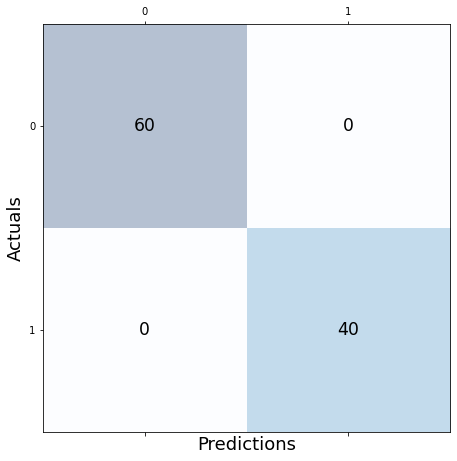

In [25]:
conf_mat = confusion_matrix(list_patients, list_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
plt.show()

Number of patients classified and no classified (didn't meet adequate Confidence Index) during MET-17 stage.

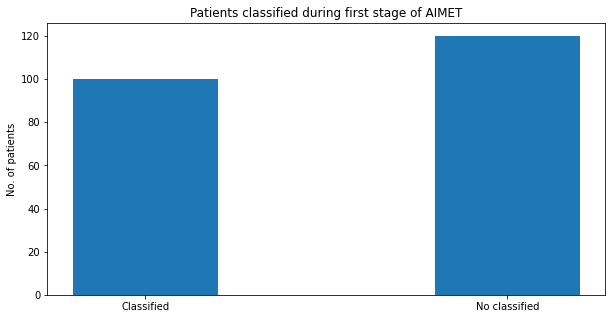

In [26]:
classes = ['Classified','No classified']
values = [TP+TN+FP+FN, len(df_17.loc[df_17['MET-17'] == 'Needs MET-30'])]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, values,
        width = 0.4)
 
# plt.xlabel("Courses offered")
plt.ylabel("No. of patients")
plt.title("Patients classified during first stage of AIMET")
plt.show()

## MET-30: Pre-processing

Columns for MET-30.

In [ ]:
columns_30 =['MRN',
             'Age (years)',
             'Gender',
             'Epidemiologic link to SARS-CoV-2', 
             'FEVER fever before hospital ', 
             'FEVER Tmax xxx or greater until next degree ',
             'Lowest systolic BP in ED (within first two hours of presentation)',
             'Lowest diastolic BP in ED (within first two hours of presentation)',
             'Highest heart rate in ED (within first two hours of presentation)',
             'Antecedent Illness',
             'Conjunctivitis', 
             'Rash', 
             'Adenopathy',
             'Mucosal changes (Strawberry tongue, cracking lips) ', 
             'Hand/foot edema ', 
             'GI involvement (nausea/vomiting, abdominal pain, diarrhea)', 
             'Neuro involvement (AMS, headache, encepalopathy)',
             'MSK involvement (arthralgias, arthritis, myalgias) ',
             'Respiratory involvement (tachypnea, respiratory distress, cough, pneumonia, etc)',
             'Cardiac involvement (chest pain, arrhythmia)',
             'WBC, admission',
             'ALC, admission',
             'ANC, admission',
             'Platelets, admission',
             'AST, admission',
             'ALT, admission',
             'Sodium, admission',
             'Troponin, admission',
             'BNP, admission',
             'Fibrinogen, admission',
             'LDH',
             'PATIENT HAD TYPHUS?',
             'PATIENT HAD MISC?']

Dataframe for MET-30 with patients that didn't meet an adequate Confidence Index in MET-17.

In [30]:
df_30 = df[columns_30].loc[df_17['MET-17']=='Needs MET-30']

Categorization of the LDH clinical feature based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [31]:
df_30 = int2cat(df= df_30, column='LDH', low=223, high=409, gender='Female', age=[0,4])
df_30 = int2cat(df= df_30, column='LDH', low=209, high=401, gender='Female', age=[4,7])
df_30 = int2cat(df= df_30, column='LDH', low=187, high=334, gender='Female', age=[7,10])
df_30 = int2cat(df= df_30, column='LDH', low=169, high=343, gender='Female', age=[10,12])
df_30 = int2cat(df= df_30, column='LDH', low=169, high=285, gender='Female', age=[12,14])
df_30 = int2cat(df= df_30, column='LDH', low=174, high=258, gender='Female', age=[14,16])
df_30 = int2cat(df= df_30, column='LDH', low=151, high=298, gender='Female', age=[16,25])
df_30 = int2cat(df= df_30, column='LDH', low=223, high=409, gender='Male', age=[0,4])
df_30 = int2cat(df= df_30, column='LDH', low=209, high=401, gender='Male', age=[4,7])
df_30 = int2cat(df= df_30, column='LDH', low=187, high=334, gender='Male', age=[7,10])
df_30 = int2cat(df= df_30, column='LDH', low=192, high=312, gender='Male', age=[10,12])
df_30 = int2cat(df= df_30, column='LDH', low=209, high=334, gender='Male', age=[12,14])
df_30 = int2cat(df= df_30, column='LDH', low=160, high=325, gender='Male', age=[14,16])
df_30 = int2cat(df= df_30, column='LDH', low=151, high=298, gender='Male', age=[16,25])

Categorization of the AST clinical feature based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [32]:
df_30 = int2cat(df= df_30, column='AST, admission', low=20, high=60, gender='Female', age=[0,4])
df_30 = int2cat(df= df_30, column='AST, admission', low=15, high=50, gender='Female', age=[4,7])
df_30 = int2cat(df= df_30, column='AST, admission', low=15, high=40, gender='Female', age=[7,10])
df_30 = int2cat(df= df_30, column='AST, admission', low=10, high=40, gender='Female', age=[10,12])
df_30 = int2cat(df= df_30, column='AST, admission', low=10, high=30, gender='Female', age=[12,16])
df_30 = int2cat(df= df_30, column='AST, admission', low=5,  high=30, gender='Female', age=[16,25])
df_30 = int2cat(df= df_30, column='AST, admission', low=20, high=60, gender='Male', age=[0,4])
df_30 = int2cat(df= df_30, column='AST, admission', low=15, high=50, gender='Male', age=[4,7])
df_30 = int2cat(df= df_30, column='AST, admission', low=15, high=40, gender='Male', age=[7,10])
df_30 = int2cat(df= df_30, column='AST, admission', low=10, high=60, gender='Male', age=[10,12])
df_30 = int2cat(df= df_30, column='AST, admission', low=15, high=40, gender='Male', age=[12,16])
df_30 = int2cat(df= df_30, column='AST, admission', low=10, high=45, gender='Male', age=[16,25])

Categorization of the ALT clinical feature based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [33]:
df_30 = int2cat(df= df_30, column='ALT, admission', low=14, high=45, gender='Female', age=[0,4])
df_30 = int2cat(df= df_30, column='ALT, admission', low=11, high=28, gender='Female', age=[4,14])
df_30 = int2cat(df= df_30, column='ALT, admission', low=10, high=35, gender='Female', age=[14,25])
df_30 = int2cat(df= df_30, column='ALT, admission', low=12, high=45, gender='Male', age=[0,4])
df_30 = int2cat(df= df_30, column='ALT, admission', low=10, high=41, gender='Male', age=[4,14])
df_30 = int2cat(df= df_30, column='ALT, admission', low=11, high=26, gender='Male', age=[14,25])

Categorization of the clinical features Sodium, Troponin, Fibrinogen, WBC, ALC, ANC, Platelets, and BNP based on the Texas Children’s Hospital Pathology Catalog Standard References.

In [34]:
df_30 = int2cat(df= df_30, column='Sodium, admission', low=135, high=None, gender=None, age=None)
df_30 = int2cat(df= df_30, column='Troponin, admission', low=None, high=0.03, gender=None, age=None)
df_30 = int2cat(df= df_30, column='Fibrinogen, admission', low=220, high=440, gender=None, age=None)
df_30 = int2cat(df= df_30, column='WBC, admission', low=4, high=11, gender=None, age=None)
df_30 = int2cat(df= df_30, column='ALC, admission', low=1500, high=None, gender=None, age=None)
df_30 = int2cat(df= df_30, column='ANC, admission', low=None, high=8, gender=None, age=None)
df_30 = int2cat(df= df_30, column='Platelets, admission', low=200, high=500, gender=None, age=None)
df_30 = int2cat(df= df_30, column='BNP, admission', low=None, high=200, gender=None, age=None)

Binary encoding for categorical features.

In [35]:
df_30 = bin_encoding(df=df_30, column='Gender', zero='Female', one='Male')
df_30 = bin_encoding(df=df_30, column='Epidemiologic link to SARS-CoV-2', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Antecedent Illness', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Conjunctivitis', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Rash', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Adenopathy', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Mucosal changes (Strawberry tongue, cracking lips) ', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Hand/foot edema ', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='GI involvement (nausea/vomiting, abdominal pain, diarrhea)', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Neuro involvement (AMS, headache, encepalopathy)', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='MSK involvement (arthralgias, arthritis, myalgias) ', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Respiratory involvement (tachypnea, respiratory distress, cough, pneumonia, etc)', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='Cardiac involvement (chest pain, arrhythmia)', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='PATIENT HAD TYPHUS?', zero='No', one='Yes')
df_30 = bin_encoding(df=df_30, column='PATIENT HAD MISC?', zero='No', one='Yes')

Creation of the ANC /ALC ratio, admission feature.

In [36]:
df_30['ANC/ALC ratio, admission'] = df['ANC, admission']/df['ALC, admission']

Data imputation for continuous values.

In [37]:
df_30['FEVER fever before hospital '].fillna(df_30['FEVER fever before hospital '].mean() ,inplace=True)
df_30['FEVER Tmax xxx or greater until next degree '].fillna(df_30['FEVER Tmax xxx or greater until next degree '].mean() ,inplace=True)
df_30['Highest heart rate in ED (within first two hours of presentation)'].fillna(df_30['Highest heart rate in ED (within first two hours of presentation)'].mean() ,inplace=True)
df_30['Lowest systolic BP in ED (within first two hours of presentation)'].fillna(df_30['Lowest systolic BP in ED (within first two hours of presentation)'].mean() ,inplace=True)
df_30['Lowest diastolic BP in ED (within first two hours of presentation)'].fillna(df_30['Lowest diastolic BP in ED (within first two hours of presentation)'].mean() ,inplace=True)
df_30['ANC/ALC ratio, admission'].fillna(df_30['ANC/ALC ratio, admission'].mean() ,inplace=True)

Creation of dummies to scale the patients' values based on the values with which the MET-30 was previously trained.

In [40]:
index_dummy = max(df_30.index)

In [41]:
df_30.loc[index_dummy+1] = ['Dummy 01', 0.75, 0, 0, 0, 100, 60, 17, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.27]

In [42]:
df_30.loc[index_dummy+1]

MRN                                 Dummy 01
Age (years)                             0.75
Gender                                     0
Epidemiologic link to SARS-CoV-2           0
FEVER fever before hospital                0
                                      ...   
Platelets, admission - High                0
Platelets, admission - Normal              0
BNP, admission - High                      0
BNP, admission - Normal                    0
ANC/ALC ratio, admission                0.27
Name: 217, Length: 62, dtype: object

In [43]:
df_30.loc[index_dummy+2] = ['Dummy 02', 19, 1, 1, 15, 106.2, 134, 123, 200, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 121.36]

In [44]:
df_30.loc[index_dummy+2]

MRN                                 Dummy 02
Age (years)                               19
Gender                                     1
Epidemiologic link to SARS-CoV-2           1
FEVER fever before hospital               15
                                      ...   
Platelets, admission - High                1
Platelets, admission - Normal              1
BNP, admission - High                      1
BNP, admission - Normal                    1
ANC/ALC ratio, admission              121.36
Name: 218, Length: 62, dtype: object

Min-Max Scaling.

In [45]:
scaler = MinMaxScaler()
df_30[['FEVER fever before hospital ',
       'Age (years)',
       'Highest heart rate in ED (within first two hours of presentation)',
       'Lowest systolic BP in ED (within first two hours of presentation)',
       'Lowest diastolic BP in ED (within first two hours of presentation)',
       'ANC/ALC ratio, admission',
       'FEVER Tmax xxx or greater until next degree ']] = scaler.fit_transform(df_30[['FEVER fever before hospital ',
                                                                                      'Age (years)',
                                                                                      'Highest heart rate in ED (within first two hours of presentation)',
                                                                                      'Lowest systolic BP in ED (within first two hours of presentation)',
                                                                                      'Lowest diastolic BP in ED (within first two hours of presentation)',
                                                                                      'ANC/ALC ratio, admission',
                                                                                      'FEVER Tmax xxx or greater until next degree ']])

Dummies' dropping.

In [46]:
df_30 = df_30.drop([index_dummy+1, index_dummy+2])

No-need features' dropping.

In [47]:
df_30 = df_30.drop(['WBC, admission',
                    'ALC, admission',
                    'ANC, admission',
                    'Platelets, admission',
                    'AST, admission',
                    'ALT, admission',
                    'Sodium, admission',
                    'Troponin, admission',
                    'Fibrinogen, admission',
                    'BNP, admission',
                    'LDH'], axis=1)

MET-30 dataframe after all pre-processing processes.

In [48]:
df_30

,MRN,Age (years),Gender,Epidemiologic link to SARS-CoV-2,FEVER fever before hospital,FEVER Tmax xxx or greater until next degree,Lowest systolic BP in ED (within first two hours of presentation),Lowest diastolic BP in ED (within first two hours of presentation),Highest heart rate in ED (within first two hours of presentation),Antecedent Illness,...,"ALC, admission - Low","ALC, admission - Normal","ANC, admission - High","ANC, admission - Normal","Platelets, admission - Low","Platelets, admission - High","Platelets, admission - Normal","BNP, admission - High","BNP, admission - Normal","ANC/ALC ratio, admission"
0,FRHQ53971,0.890411,0,1,0.666667,0.806452,0.202703,0.207547,0.395683,0,...,1,0,1,0,0,0,1,1,0,0.115358
2,SDBJ73753,0.232877,1,0,0.333333,0.483871,0.472973,0.339623,0.424460,0,...,1,0,0,1,0,0,1,0,1,0.041266
3,JLFE85476,0.232877,1,0,0.333333,0.645161,0.621622,0.386792,0.395683,0,...,1,0,0,1,1,0,0,0,1,0.070265
4,GCKX65582,0.506849,0,1,0.333333,0.483871,0.418919,0.339623,0.669065,0,...,1,0,0,1,1,0,0,0,0,0.045170
5,GAPP44528,0.035616,1,0,0.200000,0.483871,0.527027,0.481132,0.827338,1,...,1,0,1,0,0,0,1,1,0,0.051280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,KALX38749,0.561644,0,0,0.400000,0.483871,0.540541,0.471698,0.410072,0,...,1,0,0,1,1,0,0,0,1,0.049781
211,FPJF83987,0.780822,1,0,0.933333,0.322581,0.891892,0.471698,0.374101,0,...,1,0,0,1,1,0,0,0,1,0.069026
213,CFWM78145,0.835616,0,0,0.400000,0.483871,0.851351,0.566038,0.474820,0,...,1,0,0,1,1,0,0,0,1,0.019706
215,KBXJ26432,0.890411,1,0,0.600000,0.483871,0.675676,0.330189,0.273381,0,...,1,0,1,0,1,0,0,0,1,0.226080


## MET-30: Evaluation

Pre-processed columns to use for MET-30.

In [49]:
columns =['Age (years)', 
         'Epidemiologic link to SARS-CoV-2', 
         'FEVER fever before hospital ', 
         'FEVER Tmax xxx or greater until next degree ',
         'Lowest systolic BP in ED (within first two hours of presentation)',
         'Lowest diastolic BP in ED (within first two hours of presentation)',
         'Highest heart rate in ED (within first two hours of presentation)',
         'Antecedent Illness',
         'Conjunctivitis', 
         'Rash', 
         'Adenopathy',
         'Mucosal changes (Strawberry tongue, cracking lips) ', 
         'Hand/foot edema ', 
         'GI involvement (nausea/vomiting, abdominal pain, diarrhea)', 
         'Neuro involvement (AMS, headache, encepalopathy)',
         'MSK involvement (arthralgias, arthritis, myalgias) ',
         'Respiratory involvement (tachypnea, respiratory distress, cough, pneumonia, etc)',
         'Cardiac involvement (chest pain, arrhythmia)',
         'WBC, admission - Low',
         'WBC, admission - Normal',
         'WBC, admission - High',
         'ALC, admission - Low',
         'ALC, admission - Normal',
         'ANC, admission - High',
         'Platelets, admission - Low',
         'Platelets, admission - Normal',
         'Platelets, admission - High',
         'AST, admission - Normal',
         'AST, admission - High',
         'ALT, admission - Low',
         'ALT, admission - High',
         'Sodium, admission - Normal',
         'Troponin, admission - High',
         'BNP, admission - High',
         'Fibrinogen, admission - Normal',
         'Fibrinogen, admission - High',
         'LDH - Low',
         'LDH - Normal',
         'LDH - High',
         'ANC/ALC ratio, admission']

X and Y declaration to use them in MET-30.

In [50]:
X = df_30[columns].values
X = X.astype(float)
Y = df_30[['PATIENT HAD TYPHUS?', 'PATIENT HAD MISC?']].values
Y = Y.astype(float)
X = X[:, np.newaxis, :]

Attention LSTM model (MET-30) to evaluate the patients.

In [51]:
# Define Functional Model Input
inputs_functional = tf.keras.Input(shape=X.shape[1:], name="features")

#Attention Module
attention_dense   = tf.keras.layers.Dense(X.shape[2], activation='tanh', name='attention_dense')(inputs_functional)
attention_softmax = tf.keras.layers.Dense(X.shape[2], activation='softmax', name="attention_softmax")(attention_dense)
attention_mult    = tf.keras.layers.multiply([attention_softmax, inputs_functional], name='attention_output')
  
#LSTM
lstm_01 = tf.keras.layers.LSTM(X.shape[2]*2, recurrent_dropout=0.2, name='LSTM')(attention_mult)
   
#Hidden Feature Layer
hidden_dense_01   = tf.keras.layers.Dense(X.shape[2]*4, activation='relu', name='hidden_dense_01')(lstm_01)
hidden_drop_01    = tf.keras.layers.Dropout(0.12, input_shape=(X.shape[2]*4,))(hidden_dense_01)
hidden_dense_02   = tf.keras.layers.Dense(X.shape[2]*3, activation='relu', name='hidden_dense_02')(hidden_drop_01)
hidden_drop_02    = tf.keras.layers.Dropout(0.12, input_shape=(X.shape[2]*3,))(hidden_dense_02)
hidden_dense_03   = tf.keras.layers.Dense(X.shape[2]*2, activation='relu', name='hidden_dense_03')(hidden_drop_02)
hidden_drop_03    = tf.keras.layers.Dropout(0.12, input_shape=(X.shape[2]*3,))(hidden_dense_03)
hidden_dense_04   = tf.keras.layers.Dense(X.shape[2]*2, activation='relu', name='hidden_dense_04')(hidden_drop_03)
hidden_drop_04    = tf.keras.layers.Dropout(0.12, input_shape=(X.shape[2]*2,))(hidden_dense_04)
    
#Output
output_model = tf.keras.layers.Dense(2, activation='softmax', name='output')(hidden_drop_04)
  
#Model
model = tf.keras.Model(inputs=inputs_functional, outputs=[output_model])

In [52]:
model = tf.keras.Model(inputs=inputs_functional, outputs=[output_model])

In [53]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 1, 40)]      0                                            
__________________________________________________________________________________________________
attention_dense (Dense)         (None, 1, 40)        1640        features[0][0]                   
__________________________________________________________________________________________________
attention_softmax (Dense)       (None, 1, 40)        1640        attention_dense[0][0]            
__________________________________________________________________________________________________
attention_output (Multiply)     (None, 1, 40)        0           attention_softmax[0][0]          
                                                                 features[0][0]             

Pre-trained MET-30's loading.

In [54]:
path_checkpoint = cwd + '/Models/LSTM_checkpoint_PC_40100A-v8.keras'
model.load_weights(path_checkpoint)
y_pred = model.predict(X)

MET-30 evaluation for every patient in the dataframe.

In [55]:
y_pred[:,0] = np.round_(y_pred[:,0])
conf_mat = confusion_matrix(Y[:,0], y_pred[:,0])
print(conf_mat)

[[73  0]
 [ 0 47]]


Confusion Matrix parameters and computation.

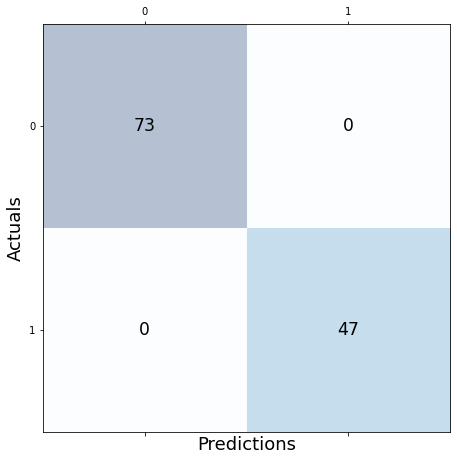

In [56]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
plt.show()